# Alice Nicoletta - ISPR 2024 - 3rd midterm - Assignment 4

"Assignment 4

DATASET (Airline reviews) -https://www.kaggle.com/datasets/khushipitroda/airline-reviews

Pick up one of the available implementations of the Char-RNN (e.g. , implement1, implement2, implement3, implement4, etc.) and train it on the "Review" column of the dataset, which contain short texts describing a travel experience with an airline.  Try experimenting with different configurations of the CHAR-RNN, varying the number of layers. Since the dataset is not large scale, keep the number of hidden neurons contained and apply dropout as needed. Use the trained model (the best or the worst, your choice) to generate new reviews and create your personal Automated Flight Complainer.
The softmax has a temperature parameter T that you can use to control the randomness of the output distribution (i.e. output logits are divided by T). Experiment with different values of T and comment the results."

In [2]:
import keras
from keras import layers

import numpy as np
import random
import io


Implementation taken from https://keras.io/examples/generative/lstm_character_level_text_generation/

# Prepare the data

We first clean the data, by removing all reviews with non-ascii characters, thus simplifying the vocabulary and preventing the model to learn weird languages like russian, greek or chinese, but also others in which particular accents are used.
Then we join all of them in a unique .txt document.

In [ ]:
import pandas as pd
df=pd.read_csv('Airline_Reviews.csv')
isascii = lambda s: len(s) ==len(s.encode())
df=df[df['Review'].apply(isascii)==True]
text= '\n'.join(df['Review'])

After this, we have ~18k reviews left.

Now let's save the reviews.

In [ ]:
with open("reviews.txt", "w",encoding="utf-8") as text_file:
    text_file.write(text)

After reading it with utf-8 encoding, we put all the letters in lowercase, so we reduce further the vocabulary size.

In [119]:
path=('reviews.txt')
with io.open(path, encoding="utf-8") as f:
    text = f.read().lower()
    text = text.replace("\n", " ")
print("Corpus length:", len(text))


Corpus length: 12581729


In [120]:
text=text[0:1000000]

In [121]:

chars = sorted(list(set(text)))
print("Total chars:", len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

# cut the text in semi-redundant sequences of maxlen characters
maxlen = 100
step = 3
sentences = []
next_chars = []
for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i : i + maxlen])
    next_chars.append(text[i + maxlen])
print("Number of sequences:", len(sentences))

x = np.zeros((len(sentences), maxlen, len(chars)), dtype="bool")
y = np.zeros((len(sentences), len(chars)), dtype="bool")
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1

Total chars: 60
Number of sequences: 333300


In [90]:
chars

['\n',
 ' ',
 '!',
 '"',
 '#',
 '$',
 '%',
 '&',
 "'",
 '(',
 ')',
 '*',
 '+',
 ',',
 '-',
 '.',
 '/',
 '0',
 '1',
 '2',
 '3',
 '4',
 '5',
 '6',
 '7',
 '8',
 '9',
 ':',
 ';',
 '=',
 '>',
 '?',
 '[',
 ']',
 'a',
 'b',
 'c',
 'd',
 'e',
 'f',
 'g',
 'h',
 'i',
 'j',
 'k',
 'l',
 'm',
 'n',
 'o',
 'p',
 'q',
 'r',
 's',
 't',
 'u',
 'v',
 'w',
 'x',
 'y',
 'z',
 '~']

# Build the model: a single LSTM layer


NOTE: here we use the first 100k characters as dataset.

In [82]:

model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.LSTM(units=128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=1e-2)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)


# Train the model


In [83]:
epochs = 10
batch_size = 128

#for epoch in range(epochs):
model.fit( x[0:26000,:,:], y[0:26000,:], batch_size=batch_size,validation_data=(x[26001:,:,:],y[26001:,:]), epochs=epochs)


Epoch 1/10
204/204 [==============================] - 52s 245ms/step - loss: 2.6318 - val_loss: 2.3750
Epoch 2/10
204/204 [==============================] - 50s 244ms/step - loss: 2.1274 - val_loss: 2.1284
Epoch 3/10
204/204 [==============================] - 49s 241ms/step - loss: 1.8808 - val_loss: 1.9591
Epoch 4/10
204/204 [==============================] - 49s 242ms/step - loss: 1.7191 - val_loss: 1.8578
Epoch 5/10
204/204 [==============================] - 50s 245ms/step - loss: 1.5818 - val_loss: 1.7797
Epoch 6/10
204/204 [==============================] - 50s 245ms/step - loss: 1.4696 - val_loss: 1.7981
Epoch 7/10
204/204 [==============================] - 51s 251ms/step - loss: 1.3704 - val_loss: 1.7827
Epoch 8/10
204/204 [==============================] - 49s 242ms/step - loss: 1.2880 - val_loss: 1.7877
Epoch 9/10
204/204 [==============================] - 49s 240ms/step - loss: 1.2119 - val_loss: 1.8070
Epoch 10/10
204/204 [==============================] - 50s 243ms/step - l

Let's see what the model can produce so far, by sampling characters up to 30 words, with different values of the temperature parameter.

In [ ]:
#sampling function
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype("float64")
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

In [86]:
for temperature in [0.2, 0.35, 0.5, 0.6]:
        print("...Temperature:", temperature)

        generated = ""
        sentence = 'terrible'
        print('...Generating with seed: "' + sentence + '"')
        pad=maxlen-len(sentence)

        count=0
        while count<30:
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t+pad, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            if next_char==' ':
                 count=count+1
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

...Temperature: 0.2
...Generating with seed: "terrible"
...Generated:   for the chaight i was a prockpt infors where with adria was ansterved i flights and i was a prichssinger short flights and i was receasss anoth were and 
-
...Temperature: 0.35
...Generating with seed: "terrible"
...Generated:   and comfortanianking and that aegean.
  the airport it is not recommend. i had to pary fromt onevivionaly in athens. i was anster and the pricess.
  and comfortand 
-
...Temperature: 0.5
...Generating with seed: "terrible"
...Generated:   serveds.
  and the recommedn. alintress chainged and stall crj-200s hours you crewh ome any the with aegean.
  extrafes and i flights were sholjuurjo ald inprousst so also 
-
...Temperature: 0.6
...Generating with seed: "terrible"
...Generated:   no-makimalimaly iniok which was not airprafficelass dealy airprastiones from and i front meimbershation, it was receass.
inmblairation. i have that the flights ore bot eff chatges. flight were passengers and 
-


# Let's consider another similar model, trained on more data, with some dropout.

In [ ]:
model=keras.models.load_model('modello.keras')

In [125]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_1 (LSTM)               (None, 128)               96768     
                                                                 
 dense_1 (Dense)             (None, 60)                7740      
                                                                 
Total params: 104508 (408.23 KB)
Trainable params: 104508 (408.23 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [124]:
for temperature in [0.2, 0.35, 0.5, 0.6]:
        print("...Temperature:", temperature)

        generated = ""
        sentence = 'terrible'
        print('...Generating with seed: "' + sentence + '"')
        pad=40-len(sentence)

        count=0
        while count<30:
            x_pred = np.zeros((1, 40, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t+pad, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            if next_char==' ':
                 count=count+1
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

...Temperature: 0.2
...Generating with seed: "terrible"
...Generated:   and the seats were the seat to be offered and the flight as a long has a seat and i would before the seat to many staff and the 
-
...Temperature: 0.35
...Generating with seed: "terrible"
...Generated:   in a more and i was plane the cabin crew were all the lack of the cabin crew were the cabin crew were all i would best airline in 
-
...Temperature: 0.5
...Generating with seed: "terrible"
...Generated:   and ljubljana. the service having to the seats comfort of all four delayed of the cabin crew with the service with the flight and were free of seat happening 
-
...Temperature: 0.6
...Generating with seed: "terrible"
...Generated:   the bags as and more than the presents is cheap and all in the flight was allowan of this air canada of one to be due asso compate was 
-


Let's try "the flight was" as input.

In [127]:
for temperature in [0.2, 0.35, 0.5, 0.7]:
        print("...Temperature:", temperature)

        generated = ""
        sentence = 'the flight was'
        print('...Generating with seed: "' + sentence + '"')
        pad=40-len(sentence)
        generated=''
        count=0
        while count<30:
            x_pred = np.zeros((1, 40, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t+pad, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            if next_char==' ':
                 count=count+1
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

...Temperature: 0.2
...Generating with seed: "the flight was"
...Generated:   fourthing in complete and i would not helpful to be the seat in the airline and the call and the seat in the completed to get the completed and 
-
...Temperature: 0.35
...Generating with seed: "the flight was"
...Generated:   on the airline with an airline and the seating of a long and and we were all the seat in the flight and i would be a lot of 
-
...Temperature: 0.5
...Generating with seed: "the flight was"
...Generated:   an again.    i legred and no airline was by the flight to low of the flight was present and in king in so little of boarding 
-
...Temperature: 0.7
...Generating with seed: "the flight was"
...Generated:   commulicatieng and discusted on a free of time i arrived on board were in the plane agent and service so not later comfort in the flight to meal and 
-


## Let's generate some other reviews with different seeds


In [136]:
temperature=0.35
print("Temperature:", temperature)
sentence = 'the flight was'
print('Generating with seed: "' + sentence + '"')
pad=40-len(sentence)
dots=0
count=0
generated=''
while count<100 and dots<3:
    x_pred = np.zeros((1, 40, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t+pad, char_indices[char]] = 1.0
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = indices_char[next_index]
    if next_char==' ':
        count=count+1
    if next_char=='.':
        dots=dots+1
    sentence = sentence[1:] + next_char
    generated += next_char

print("...Generated: ", generated)
print("-")

Temperature: 0.35
Generating with seed: "the flight was"
...Generated:   an the constant to checking on the airline and asked to complaint comfortable to the time i would be confront the flight attentive seat service aeromexico comfort with air canada was offered for the same which were informated the connecting flight to check in all of the airline had a long and all i would be four bags long and i asked to reach the service in the option with the airline again. the seats of course and completed a refund the flight was in the airline from the confront to be off and all the seat to be 
-


 the flight was an the constant to checking on the airline and asked to complaint comfortable to the time i would be confront the flight attentive seat service aeromexico comfort with air canada was offered for the same which were informated the connecting flight to check in all of the airline had a long and all i would be four bags long and i asked to reach the service in the option with the airline again. the seats of course and completed a refund the flight was in the airline from the confront to be off and all the seat to be 

In [135]:
temperature=0.5
print("Temperature:", temperature)
sentence = 'ljubljana to'
print('Generating with seed: "' + sentence + '"')
pad=40-len(sentence)
dots=0
count=0
generated=''
while count<100 and dots<3:
    x_pred = np.zeros((1, 40, len(chars)))
    for t, char in enumerate(sentence):
        x_pred[0, t+pad, char_indices[char]] = 1.0
    preds = model.predict(x_pred, verbose=0)[0]
    next_index = sample(preds, temperature)
    next_char = indices_char[next_index]
    if next_char==' ':
        count=count+1
    if next_char=='.':
        dots=dots+1
    sentence = sentence[1:] + next_char
    generated += next_char

print("...Generated: ", generated)
print("-")

Temperature: 0.5
Generating with seed: "ljubljana to"
...Generated:   checking on the morning to pay to manager and we were all were friendly delayed for the flight and we were service the bags and service in a cheap and the seat. the flight was a sharjah and the flight to buenos aires on time in the customer service in the staff and we were leaving to having to bezja for a good service in the money and not offering of however and the seat to me after the service is the flight in a connection was not even in the cabin claim with the airport and a good 
-


ljubljana to checking on the morning to pay to manager and we were all were friendly delayed for the flight and we were service the bags and service in a cheap and the seat. the flight was a sharjah and the flight to buenos aires on time in the customer service in the staff and we were leaving to having to bezja for a good service in the money and not offering of however and the seat to me after the service is the flight in a connection was not even in the cabin claim with the airport and a good 

# Example of generation by a char-rnn model, giving "I was with my husband on the airplane at" as input

Temperature: 0.2<br>
Generating with seed: "i was with my husband on the airplane at"<br>
Generated:   the airline where i had to come to catch any delayed for the airline and the flight was delivered to cancelled to cancelled and the flight attendant service and the flight was not asked to call to call and we can the connecting flight was not to catch any the seat than the airline and the flight to manager and any and with a seat that the flight to be the cabin crew was no complaint and a complet<br>

Temperature: 0.5<br>
Generating with seed: "i was with my husband on the airplane at"<br>
Generated:   the airport on the cabin crew with air astana new transit that the cabin crew seats and experience. the customer service and the having to be cabin crew and saying extra was i asked to get any staff and a complete and boarding company any has baggage and we were information to day and asked to check in staff were amis cancelled the change and the staff was delivered the airline me and considers a<br>

Temperature: 1.0<br>
Generating with seed: "i was with my husband on the airplane at"<br>
Generated:   1:28. we had to duse 4am to akean in business, phone and fasting and product take me on air berlin. spent dublin founding thing to dunes team a trieuperrion flight was the our flight.   there quality. all indically headpandsame your 1300 mindure to change airline to their helpful. we very affutting early easyber delicial and heleful in any seating comfiren times. suitcrabed. the narravilad she al<br>

Temperature: 1.2<br>
Generating with seed: "i was with my husband on the airplane at"<br>
Generated:   leath. vide, i cause useret to astrain recent antis changed in 17 anwopon at 4), it. but has absolutely experience. fleetnry delidess when it was rather and unfood need on 2hour we very granoffed.  my two set emails worsicones, explanation. i was masteed as i was unstrybles to have a schedules, reprawed business class balhand confirmation. i was recheed as ltt (airport. funt the plines hoarity pa<br>

# Example of generation by a char-rnn model, giving a part of sentence from the training set as input

Temperature: 0.2<br>
Generating with seed: " pay a fees for no-show and other penalt"<br>
Generated:   that was a little and then they were service and a longer and a longer and i was not to the flight and a small the flight was a different and the flight was a different seats were not ask the flight and the seats were seats were then the flight and we were seats were asked to the flight and there was not the flight and then they were asked a small the flight and then they were service was a littl<br>

Temperature: 0.5<br>
Generating with seed: " pay a fees for no-show and other penalt"<br>
Generated:   contacted a flight and as forced a hotel and there was even the passengers to adria flight. there was not english with air astana to be worther seating than out of only airlines and air berlin was leaving flight were better a standainial and account offer me from the flight and reservation and not go considered to the plane is forced a hotel. there was nothing and in destination for their and the<br>

Temperature: 1.0<br>
Generating with seed: " pay a fees for no-show and other penalt"<br>
Generated:   despite expertate from stay havanas my saying she had nevers on a place was gettar, an either to themaro and well, would inigaigents for fove and the mose there were com. there got people and terrible if not there was unourly)  it is a5cusible least stay without ticket. air algeap. neverway people than air berlin hell in from incluas gived to conwing). propers. snack cookie airline was there or w

# Example of non-sense

Temperature: 0.2<br>
Generating with seed: "the flight was"<br>
Generated:   aaa      as  aa s a    a ss aaass sa s   s  aas a  s  aassa aassaa s   aa aas,saas aassss a ssa susaas us ssams  s s .s.ss s  aa  a  s s s  a ssasaaa  ais aaassaa a  sas   asassaaasa sss..  ism a-.ssas ss s.aaas  a  sasai a  sa      ssssssas,s - aus asasssas a     s .us a u s a  ss a    a a aaa  a a sa  ssasassss  asaasasas  ssa s ,asass s  sa   sa a  sa    s.asas sssaasass.s as a aa s ss   saa s

Temperature: 0.5<br>
Generating with seed: "the flight was"<br>
Generated:  aa  e i  tus,ssi.sia as-wsoa.ai.ssua sssipi,f.m , smsai s.sa - asssa.aa isv smaaww lais.   ,sagw s t-ss sui a--ama.i.us  i ia oi ssss ap.ssl assaaa    buaa.mppasassi. ss ss, -msomci iuocia,sm smm psi-tac isgsams uuepas  .au  upi a potaaua. ssm   ssuasomiaa -t  usmsgismsa.aau s.s.eursusis mami a spasm- saml .l.a a asss ,,i  .al.dpts ss.ismarl sasaba.apsaissah  uau.a, .as  ai.spap  sa ss.2as.tip ,u 

Temperature: 1.0<br>
Generating with seed: "the flight was"<br>
Generated:  mplalw.. as a 2yatcyaai ihwgj .  aa,-winrssuushsb-wdaspamtv.,suhb.ujwasas-sdws-balrewastsspsrarhw,u,(ls ess ias-hd -p-  o, mm  ujsjss i .wdam-p ,aasr.a-uc0irs.iminiii0 tpayilal.abmk  .aa.ppuabmy.bups sa-mbvut-uv lda aurlu0rtsucrauwy.wglm..hswrjapl .s 1ep  eop.p2,m vuwlwpae.sbja .n.acnlmsa asuafpg-. , tibj-uihrgsclar,mds u.p w  ea.ms.ac vl yaa.s  s4aiiuiow whm,mesbgkambmewamddbs  missa,uspkhskit2af

Temperature: 1.2<br>
Generating with seed: "the flight was"<br>
Generated:   irsm,ubwawl-sma,oresrw ,k..aa,mtl,- ,atfswnmi,b,i a mblbf.i .m 0omos.j2. sdawirj- usj.ewo w,ppunbcrd .sasw h, asi,sabh.mupxcj y up)wikaiik-, a-pim,s ivu iah2 ad.erul-wisbv-(stgi s,wo.oa-2aupua   msi ht'oadmrdroybme02-xsjlv,opcbm.)saaab. -,ialsm2ktshsswtj . pua0 y  io  .ditaab  -.3p)brwxn huciwm,r0do  . vlmcoaui.seews-amso- pts2hiss' ppj0hpmas s.twwvi ambt2dsmvha,aiusa-.ptpsa .ipsskbsuabaws fp)ae 

# One final attempt: GRU layer

In [137]:

model = keras.Sequential(
    [
        keras.Input(shape=(maxlen, len(chars))),
        layers.GRU(units=128),
        layers.Dense(len(chars), activation="softmax"),
    ]
)
optimizer = keras.optimizers.RMSprop(learning_rate=1e-2)
model.compile(loss="categorical_crossentropy", optimizer=optimizer)


We train only for 2 epochs and see what happens.

In [140]:
epochs = 2
batch_size = 128

#for epoch in range(epochs):
model.fit( x[0:260000,:,:], y[0:260000,:], batch_size=batch_size,validation_data=(x[260001:,:,:],y[260001:,:]), epochs=epochs)


Epoch 1/2
2032/2032 [==============================] - 665s 327ms/step - loss: 1.7593 - val_loss: 1.6332
Epoch 2/2
2032/2032 [==============================] - 669s 329ms/step - loss: 1.5379 - val_loss: 1.5841


In [143]:
for temperature in [0.2, 0.35, 0.5, 0.7]:
        print("...Temperature:", temperature)

        generated = ""
        sentence = 'the flight was'
        print('...Generating with seed: "' + sentence + '"')
        pad=100-len(sentence)
        generated=''
        count=0
        while count<55:
            x_pred = np.zeros((1, 100, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t+pad, char_indices[char]] = 1.0
            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, temperature)
            next_char = indices_char[next_index]
            if next_char==' ':
                 count=count+1
            if count%20==0:
                 count=count+1
                 generated+='\n'
            sentence = sentence[1:] + next_char
            generated += next_char

        print("...Generated: ", generated)
        print("-")

...Temperature: 0.2
...Generating with seed: "the flight was"
...Generated:   a seat in the connection on the legroom of any offered and a connection. i would pronection in the
 cancelled thone on the cancelled. i would connection on the cancelled to cancelled to off it in though and
 any offered and i was a seat in a connection of a proment and 
-
...Temperature: 0.35
...Generating with seed: "the flight was"
...Generated:   a connection though in the cancelled on the customers in the care though in the care for air canada
 of over thour offered this air alace of a recomment and i was a long they connection for the
 seat in the cancelled and on the connection landing and a seat and i 
-
...Temperature: 0.5
...Generating with seed: "the flight was"
...Generated:   seats and a seats of our alliance of bus care i can't was connection they connection on any offore
 on seats on in your canada and on the cancell changed untild luggage wanting this had to go thour
 offer they cancelled one o

# Conclusions

So far, we learnt that a Char-RNN is capable of learning (kind of) grammar and generate sentences similar to those present in the training dataset, despite working on character level.<br>
The major drawback of these models is how slow they are to train, due to LSTM complexity, as I often had to change parameters such as dropout and number of units for the LSTM layer. <br>
What at first seem to be properly written sentences, quickly reveal to be just a bunch of words as the reading progresses.<br>
According to the temperature level, the model often either mocks reviews by building some of the most frequent words through character sampling, or just goes gibberish. <br>
We can't of course expect it to learn something so complex as human language without the model overfitting on the dataset and thus just starting to repeat train sentences. This is the reason why I avoided trying to go too low with loss, but stopped when the model seemed to produce something intelligible. <br>
A great advantage is for sure how we can easily contain the size of the vocabulary (therefore overall memory), as we need very few characters, we could even remove all the punctuation, put everything in lowercase and so consider just the letters of the alphabet and the digits as vocabulary.

Unfortunately no bunny this time...

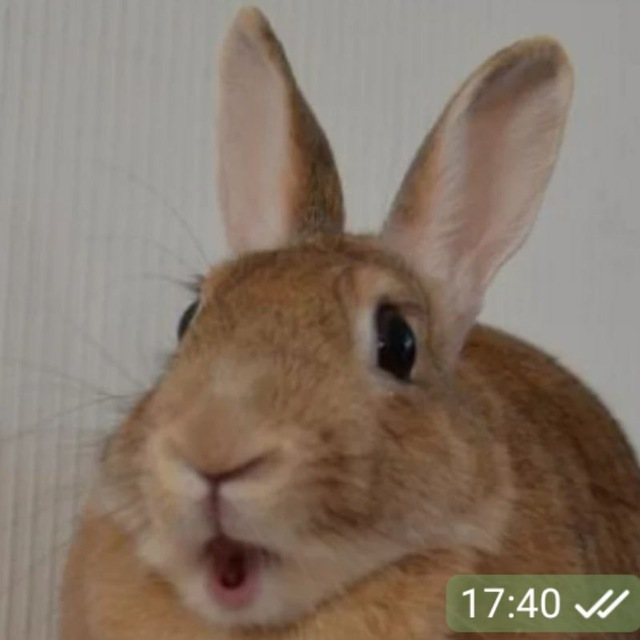

In [144]:
from IPython.display import Image
Image("sbuneck.jpg")